In [14]:
from calendar import month, week
from datetime import timedelta, datetime
from tkinter import NS
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from utils.payoff_function import calculate_option_price
from utils.evaluation import evaluate_option_price
from utils.simulation_function import SimMultiGBMAV,SimMultiGBM
from utils.extract_data_function import extract_data
from utils.counting_days_function import days
from utils.ems_correction import EMSCorrection
from utils.calculate_implied_volatility import calculate_cov_matrix
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

# Experiments with Variance Reduction

## Variance of Expected Payoff

In [132]:
n_sims = [x for x in range(50,2050,50)]

### MC Simulation

In [133]:
mc_var = {}
num_repeats = 100
for n_sim in n_sims:
    print(f'No. Of Sims: {n_sim}')
    mc_var[n_sim] = []
    for i in range(num_repeats):
        experiment_details = {
            'Nsim': n_sim,
            'latest_price_date': '2022-08-19',
            'variance_reduction': False,
            'GBM': 'multivariate',
            'r': 0.045,
            'IV': False,
            'min_sigma':0.0001,
            'max_sigma':5,
            'step':0.00001,
            'error':0.25,
            'EMS': False
        }

        aapl_barrier = 85.760
        amzn_barrier = 69.115
        googl_barrier = 58.605
        aapl_initial = 171.52
        amzn_initial = 138.23
        google_initial = 117.21

        date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
            latest_price_date=experiment_details['latest_price_date'])

#         print(f"date_to_predict: {date_to_predict}")
#         print(f"hist_end: {hist_end}")
#         print(f"end_date: {end_date}")
#         print(f"q2_to_maturity: {q2_to_maturity}")
#         print(f"q3_to_maturity: {q3_to_maturity}")
#         print(f"q2: {q2}")
#         print(f"q3: {q3}")
#         print(f"total_trading_days: {total_trading_days}")
#         print(f"holidays: {holidays}")
        trading_days_to_simulate = total_trading_days

        if experiment_details['IV']:

            aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
            aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
            amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
            amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
            googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
            googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

            min_sigma = experiment_details['min_sigma']
            max_sigma = experiment_details['max_sigma']
            error = experiment_details['error']
            step = experiment_details['step']
            sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
            right = len(sigma_hat_list)-1
            left = 0 

        predicted_option_price = []
        expected_payoff_list = []
        aapl_IV_list = []
        amzn_IV_list = []
        googl_IV_list = []

        while date_to_predict <= end_date:

            if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
                date_to_predict += relativedelta(days=+1)
                trading_days_to_simulate -= 1
                hist_end += relativedelta(days=+1)
                alternative_option_ttm-=1
                continue

            hist_start = hist_end - timedelta(days=365)

            aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
            amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
            googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
            temp_df = aapl.merge(amzn, on=['Date'])
            AAG = temp_df.merge(googl, on=['Date'])
            n0 = len(AAG)
            AAGprices = np.array(AAG.drop(columns=['Date']))
            AAGlogprices = np.log(AAGprices)
            AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

            v = np.mean(AAGlogreturns, axis=0)
            Nsim = experiment_details['Nsim']
            T = trading_days_to_simulate
            dt = 1
            m = int(T / dt)
            r = experiment_details['r']

            # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
            if experiment_details['IV']:
                sigma,aapl_IV,amzn_IV,googl_IV = calculate_cov_matrix(aapl_call_option_df,amzn_call_option_df,googl_call_option_df,r,alternative_option_ttm,sigma_hat_list,left,right,error,date_to_predict,AAGlogreturns)
                aapl_IV_list.append(aapl_IV)
                amzn_IV_list.append(amzn_IV)
                googl_IV_list.append(googl_IV)
            else:
                sigma = np.cov(AAGlogreturns,rowvar=False)

#             print(f"trading_days_to_simulate: {trading_days_to_simulate}")

            S0 = AAGprices[0, :]
            sim_aapl = []
            sim_amzn = []
            sim_googl = []

            # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
            if experiment_details['variance_reduction']:
                for i in range(1, int(Nsim/2) + 1):
                    S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
                    sim_aapl.append(S[0])
                    sim_aapl.append(Stilde[0])
                    sim_amzn.append(S[1])
                    sim_amzn.append(Stilde[1])
                    sim_googl.append(S[2])
                    sim_googl.append(Stilde[2])

            else:
                for i in range(1, Nsim + 1):
                    S,Z = SimMultiGBM(S0, v, sigma, dt, T)
                    sim_aapl.append(S[0])
                    sim_amzn.append(S[1])
                    sim_googl.append(S[2])

            if experiment_details['EMS']:
                sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
                sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
                sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

            q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
            q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

            option_prices = []
            payoff_list = []
            for i in range(Nsim):
                option_price, payoff = calculate_option_price(
                        aapl=sim_aapl[i],
                        amzn=sim_amzn[i],
                        googl=sim_googl[i],
                        T=trading_days_to_simulate,
                        total_trading_days=total_trading_days,
                        r=r,
                        q2_index=q2_index,
                        q3_index=q3_index
                    )
                option_prices.append(
                    option_price
                )
                payoff_list.append(payoff)

            expected_payoff_list.append(np.mean(payoff_list))
            mc_var[n_sim].append(np.mean(payoff_list))
            option_price = np.mean(option_prices)
            predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
#             print(f"Derivative Price for {date_to_predict}")
#             print(option_price)

            date_to_predict += relativedelta(days=+1)
            trading_days_to_simulate -= 1
            hist_end += relativedelta(days=+1)
            alternative_option_ttm-=1

No. Of Sims: 50
No. Of Sims: 100
No. Of Sims: 150
No. Of Sims: 200
No. Of Sims: 250
No. Of Sims: 300
No. Of Sims: 350
No. Of Sims: 400
No. Of Sims: 450
No. Of Sims: 500
No. Of Sims: 550
No. Of Sims: 600
No. Of Sims: 650
No. Of Sims: 700
No. Of Sims: 750
No. Of Sims: 800
No. Of Sims: 850
No. Of Sims: 900
No. Of Sims: 950
No. Of Sims: 1000
No. Of Sims: 1050
No. Of Sims: 1100
No. Of Sims: 1150
No. Of Sims: 1200
No. Of Sims: 1250
No. Of Sims: 1300
No. Of Sims: 1350
No. Of Sims: 1400
No. Of Sims: 1450
No. Of Sims: 1500
No. Of Sims: 1550
No. Of Sims: 1600
No. Of Sims: 1650
No. Of Sims: 1700
No. Of Sims: 1750
No. Of Sims: 1800
No. Of Sims: 1850
No. Of Sims: 1900
No. Of Sims: 1950
No. Of Sims: 2000


In [134]:
mc_var_dict = []

for n_sim in mc_var.keys():
    values = mc_var[n_sim]
    for val in values:
        mc_var_dict.append({'n_sims': n_sim, 'e_payoff': val})

In [135]:
mc_var_df = pd.DataFrame(mc_var_dict)

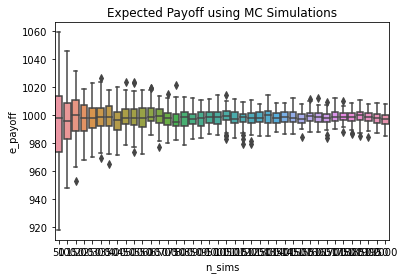

In [136]:
sns.boxplot(data=mc_var_df, x='n_sims', y='e_payoff')
plt.title('Expected Payoff using MC Simulations')
plt.show()

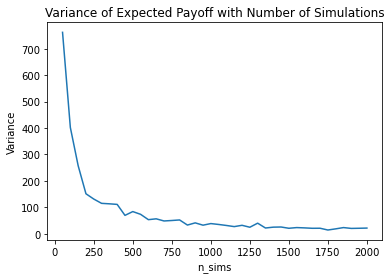

In [137]:
plt.plot(mc_var_df.groupby(by=['n_sims'])['e_payoff'].var())
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Expected Payoff with Number of Simulations')
plt.show()

### Antithetic Variates

In [138]:
av_var = {}
num_repeats = 100
for n_sim in n_sims:
    print(f'No. Of Sims: {n_sim}')
    av_var[n_sim] = []
    for i in range(num_repeats):
        experiment_details = {
            'Nsim': n_sim,
            'latest_price_date': '2022-08-19',
            'variance_reduction': True,
            'GBM': 'multivariate',
            'r': 0.045,
            'IV': False,
            'min_sigma':0.0001,
            'max_sigma':5,
            'step':0.00001,
            'error':0.25,
            'EMS': False
        }

        aapl_barrier = 85.760
        amzn_barrier = 69.115
        googl_barrier = 58.605
        aapl_initial = 171.52
        amzn_initial = 138.23
        google_initial = 117.21

        date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
            latest_price_date=experiment_details['latest_price_date'])

#         print(f"date_to_predict: {date_to_predict}")
#         print(f"hist_end: {hist_end}")
#         print(f"end_date: {end_date}")
#         print(f"q2_to_maturity: {q2_to_maturity}")
#         print(f"q3_to_maturity: {q3_to_maturity}")
#         print(f"q2: {q2}")
#         print(f"q3: {q3}")
#         print(f"total_trading_days: {total_trading_days}")
#         print(f"holidays: {holidays}")
        trading_days_to_simulate = total_trading_days

        if experiment_details['IV']:

            aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
            aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
            amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
            amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
            googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
            googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

            min_sigma = experiment_details['min_sigma']
            max_sigma = experiment_details['max_sigma']
            error = experiment_details['error']
            step = experiment_details['step']
            sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
            right = len(sigma_hat_list)-1
            left = 0 

        predicted_option_price = []
        expected_payoff_list = []
        aapl_IV_list = []
        amzn_IV_list = []
        googl_IV_list = []

        while date_to_predict <= end_date:

            if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
                date_to_predict += relativedelta(days=+1)
                trading_days_to_simulate -= 1
                hist_end += relativedelta(days=+1)
                alternative_option_ttm-=1
                continue

            hist_start = hist_end - timedelta(days=365)

            aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
            amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
            googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
            temp_df = aapl.merge(amzn, on=['Date'])
            AAG = temp_df.merge(googl, on=['Date'])
            n0 = len(AAG)
            AAGprices = np.array(AAG.drop(columns=['Date']))
            AAGlogprices = np.log(AAGprices)
            AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

            v = np.mean(AAGlogreturns, axis=0)
            Nsim = experiment_details['Nsim']
            T = trading_days_to_simulate
            dt = 1
            m = int(T / dt)
            r = experiment_details['r']

            # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
            if experiment_details['IV']:
                sigma,aapl_IV,amzn_IV,googl_IV = calculate_cov_matrix(aapl_call_option_df,amzn_call_option_df,googl_call_option_df,r,alternative_option_ttm,sigma_hat_list,left,right,error,date_to_predict,AAGlogreturns)
                aapl_IV_list.append(aapl_IV)
                amzn_IV_list.append(amzn_IV)
                googl_IV_list.append(googl_IV)
            else:
                sigma = np.cov(AAGlogreturns,rowvar=False)

#             print(f"trading_days_to_simulate: {trading_days_to_simulate}")

            S0 = AAGprices[0, :]
            sim_aapl = []
            sim_amzn = []
            sim_googl = []

            # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
            if experiment_details['variance_reduction']:
                for i in range(1, int(Nsim/2) + 1):
                    S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
                    sim_aapl.append(S[0])
                    sim_aapl.append(Stilde[0])
                    sim_amzn.append(S[1])
                    sim_amzn.append(Stilde[1])
                    sim_googl.append(S[2])
                    sim_googl.append(Stilde[2])

            else:
                for i in range(1, Nsim + 1):
                    S,Z = SimMultiGBM(S0, v, sigma, dt, T)
                    sim_aapl.append(S[0])
                    sim_amzn.append(S[1])
                    sim_googl.append(S[2])

            if experiment_details['EMS']:
                sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
                sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
                sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

            q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
            q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

            option_prices = []
            payoff_list = []
            for i in range(Nsim):
                option_price, payoff = calculate_option_price(
                        aapl=sim_aapl[i],
                        amzn=sim_amzn[i],
                        googl=sim_googl[i],
                        T=trading_days_to_simulate,
                        total_trading_days=total_trading_days,
                        r=r,
                        q2_index=q2_index,
                        q3_index=q3_index
                    )
                option_prices.append(
                    option_price
                )
                payoff_list.append(payoff)

            expected_payoff_list.append(np.mean(payoff_list))
            av_var[n_sim].append(np.mean(payoff_list))
            option_price = np.mean(option_prices)
            predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
#             print(f"Derivative Price for {date_to_predict}")
#             print(option_price)

            date_to_predict += relativedelta(days=+1)
            trading_days_to_simulate -= 1
            hist_end += relativedelta(days=+1)
            alternative_option_ttm-=1

No. Of Sims: 50
No. Of Sims: 100
No. Of Sims: 150
No. Of Sims: 200
No. Of Sims: 250
No. Of Sims: 300
No. Of Sims: 350
No. Of Sims: 400
No. Of Sims: 450
No. Of Sims: 500
No. Of Sims: 550
No. Of Sims: 600
No. Of Sims: 650
No. Of Sims: 700
No. Of Sims: 750
No. Of Sims: 800
No. Of Sims: 850
No. Of Sims: 900
No. Of Sims: 950
No. Of Sims: 1000
No. Of Sims: 1050
No. Of Sims: 1100
No. Of Sims: 1150
No. Of Sims: 1200
No. Of Sims: 1250
No. Of Sims: 1300
No. Of Sims: 1350
No. Of Sims: 1400
No. Of Sims: 1450
No. Of Sims: 1500
No. Of Sims: 1550
No. Of Sims: 1600
No. Of Sims: 1650
No. Of Sims: 1700
No. Of Sims: 1750
No. Of Sims: 1800
No. Of Sims: 1850
No. Of Sims: 1900
No. Of Sims: 1950
No. Of Sims: 2000


In [148]:
av_var_dict = []

for n_sim in av_var.keys():
    values = av_var[n_sim]
    for val in values:
        av_var_dict.append({'n_sims': n_sim, 'e_payoff': val})

In [149]:
av_var_df = pd.DataFrame(av_var_dict)

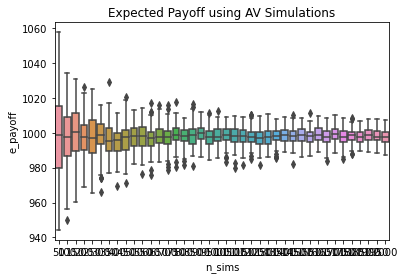

In [150]:
sns.boxplot(data=av_var_df, x='n_sims', y='e_payoff')
plt.title('Expected Payoff using AV Simulations')
plt.show()

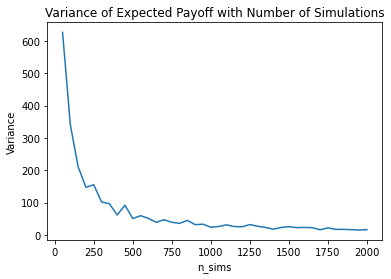

In [151]:
plt.plot(av_var_df.groupby(by=['n_sims'])['e_payoff'].var())
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Expected Payoff with Number of Simulations')
plt.show()

In [152]:
av_var_df['technique'] = 'AV'

In [153]:
mc_var_df['technique'] = 'MC'

In [154]:
var_df = pd.concat([av_var_df, mc_var_df]).reset_index(drop=True)

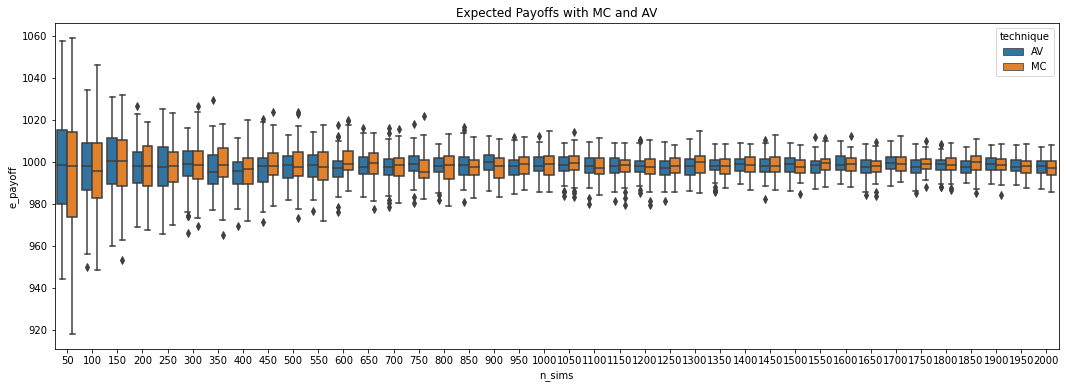

In [157]:
fig = plt.figure(figsize=(18,6))
sns.boxplot(data=var_df, x='n_sims', y='e_payoff', hue='technique')
plt.title('Expected Payoffs with MC and AV')
plt.savefig('../results/MC_vs_AV_expected_payoff')

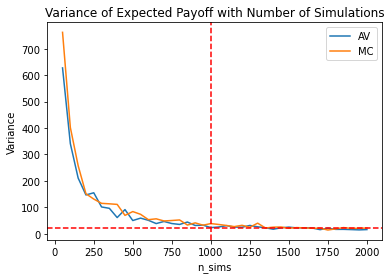

In [167]:
plt.plot(av_var_df.groupby(by=['n_sims'])['e_payoff'].var(), label='AV')
plt.plot(mc_var_df.groupby(by=['n_sims'])['e_payoff'].var(), label='MC')
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Expected Payoff with Number of Simulations')
plt.legend(loc='upper right')
plt.axhline(20, color='red', linestyle='dashed')
plt.axvline(1000, color='red', linestyle='dashed')
plt.savefig('../results/MC_vs_AV_variance_expected_payoff')

## Variance of payoff

In [93]:
mc_var_payoff = {}
for n_sim in n_sims:
    print(f'No. Of Sims: {n_sim}')
    mc_var_payoff[n_sim] = []
    
    experiment_details = {
        'Nsim': n_sim,
        'latest_price_date': '2022-08-19',
        'variance_reduction': False,
        'GBM': 'multivariate',
        'r': 0.045,
        'IV': False,
        'min_sigma':0.0001,
        'max_sigma':5,
        'step':0.00001,
        'error':0.25,
        'EMS': False
    }

    aapl_barrier = 85.760
    amzn_barrier = 69.115
    googl_barrier = 58.605
    aapl_initial = 171.52
    amzn_initial = 138.23
    google_initial = 117.21

    date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
        latest_price_date=experiment_details['latest_price_date'])

#         print(f"date_to_predict: {date_to_predict}")
#         print(f"hist_end: {hist_end}")
#         print(f"end_date: {end_date}")
#         print(f"q2_to_maturity: {q2_to_maturity}")
#         print(f"q3_to_maturity: {q3_to_maturity}")
#         print(f"q2: {q2}")
#         print(f"q3: {q3}")
#         print(f"total_trading_days: {total_trading_days}")
#         print(f"holidays: {holidays}")
    trading_days_to_simulate = total_trading_days

    if experiment_details['IV']:

        aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
        aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
        amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
        amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
        googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
        googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

        min_sigma = experiment_details['min_sigma']
        max_sigma = experiment_details['max_sigma']
        error = experiment_details['error']
        step = experiment_details['step']
        sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
        right = len(sigma_hat_list)-1
        left = 0 

    predicted_option_price = []
    expected_payoff_list = []
    aapl_IV_list = []
    amzn_IV_list = []
    googl_IV_list = []

    while date_to_predict <= end_date:

        if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
            date_to_predict += relativedelta(days=+1)
            trading_days_to_simulate -= 1
            hist_end += relativedelta(days=+1)
            alternative_option_ttm-=1
            continue

        hist_start = hist_end - timedelta(days=365)

        aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
        amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
        googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
        temp_df = aapl.merge(amzn, on=['Date'])
        AAG = temp_df.merge(googl, on=['Date'])
        n0 = len(AAG)
        AAGprices = np.array(AAG.drop(columns=['Date']))
        AAGlogprices = np.log(AAGprices)
        AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

        v = np.mean(AAGlogreturns, axis=0)
        Nsim = experiment_details['Nsim']
        T = trading_days_to_simulate
        dt = 1
        m = int(T / dt)
        r = experiment_details['r']

        # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
        if experiment_details['IV']:
            sigma,aapl_IV,amzn_IV,googl_IV = calculate_cov_matrix(aapl_call_option_df,amzn_call_option_df,googl_call_option_df,r,alternative_option_ttm,sigma_hat_list,left,right,error,date_to_predict,AAGlogreturns)
            aapl_IV_list.append(aapl_IV)
            amzn_IV_list.append(amzn_IV)
            googl_IV_list.append(googl_IV)
        else:
            sigma = np.cov(AAGlogreturns,rowvar=False)

#             print(f"trading_days_to_simulate: {trading_days_to_simulate}")

        S0 = AAGprices[0, :]
        sim_aapl = []
        sim_amzn = []
        sim_googl = []

        # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
        if experiment_details['variance_reduction']:
            for i in range(1, int(Nsim/2) + 1):
                S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
                sim_aapl.append(S[0])
                sim_aapl.append(Stilde[0])
                sim_amzn.append(S[1])
                sim_amzn.append(Stilde[1])
                sim_googl.append(S[2])
                sim_googl.append(Stilde[2])

        else:
            for i in range(1, Nsim + 1):
                S,Z = SimMultiGBM(S0, v, sigma, dt, T)
                sim_aapl.append(S[0])
                sim_amzn.append(S[1])
                sim_googl.append(S[2])

        if experiment_details['EMS']:
            sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
            sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
            sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

        q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
        q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

        option_prices = []
        payoff_list = []
        for i in range(Nsim):
            option_price, payoff = calculate_option_price(
                    aapl=sim_aapl[i],
                    amzn=sim_amzn[i],
                    googl=sim_googl[i],
                    T=trading_days_to_simulate,
                    total_trading_days=total_trading_days,
                    r=r,
                    q2_index=q2_index,
                    q3_index=q3_index
                )
            option_prices.append(
                option_price
            )
            payoff_list.append(payoff)

        expected_payoff_list.append(np.mean(payoff_list))
        mc_var_payoff[n_sim] = payoff_list
        option_price = np.mean(option_prices)
        predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
#             print(f"Derivative Price for {date_to_predict}")
#             print(option_price)

        date_to_predict += relativedelta(days=+1)
        trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
        alternative_option_ttm-=1

No. Of Sims: 50
No. Of Sims: 100
No. Of Sims: 150
No. Of Sims: 200
No. Of Sims: 250
No. Of Sims: 300
No. Of Sims: 350
No. Of Sims: 400
No. Of Sims: 450
No. Of Sims: 500
No. Of Sims: 550
No. Of Sims: 600
No. Of Sims: 650
No. Of Sims: 700
No. Of Sims: 750
No. Of Sims: 800
No. Of Sims: 850
No. Of Sims: 900
No. Of Sims: 950
No. Of Sims: 1000
No. Of Sims: 1050
No. Of Sims: 1100
No. Of Sims: 1150
No. Of Sims: 1200
No. Of Sims: 1250
No. Of Sims: 1300
No. Of Sims: 1350
No. Of Sims: 1400
No. Of Sims: 1450
No. Of Sims: 1500
No. Of Sims: 1550
No. Of Sims: 1600
No. Of Sims: 1650
No. Of Sims: 1700
No. Of Sims: 1750
No. Of Sims: 1800
No. Of Sims: 1850
No. Of Sims: 1900
No. Of Sims: 1950
No. Of Sims: 2000


In [94]:
mc_var_dict = []

for n_sim in mc_var_payoff.keys():
    values = mc_var_payoff[n_sim]
    for val in values:
        mc_var_dict.append({'n_sims': n_sim, 'payoff': val})

In [95]:
mc_var_df = pd.DataFrame(mc_var_dict)

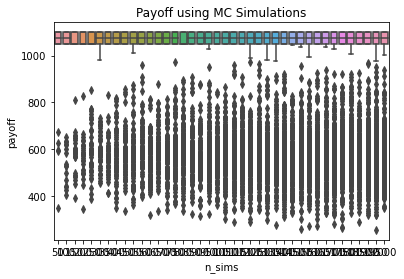

In [96]:
sns.boxplot(data=mc_var_df, x='n_sims', y='payoff')
plt.title('Payoff using MC Simulations')
plt.show()

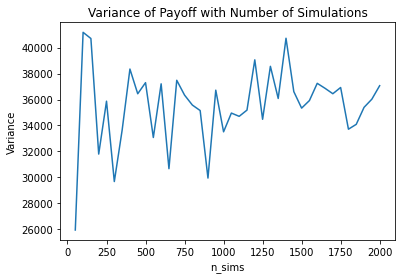

In [97]:
plt.plot(mc_var_df.groupby(by=['n_sims'])['payoff'].var())
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Payoff with Number of Simulations')
plt.show()

In [98]:
av_var_payoff = {}
for n_sim in n_sims:
    print(f'No. Of Sims: {n_sim}')
    av_var_payoff[n_sim] = []
    
    experiment_details = {
        'Nsim': n_sim,
        'latest_price_date': '2022-08-19',
        'variance_reduction': True,
        'GBM': 'multivariate',
        'r': 0.045,
        'IV': False,
        'min_sigma':0.0001,
        'max_sigma':5,
        'step':0.00001,
        'error':0.25,
        'EMS': False
    }

    aapl_barrier = 85.760
    amzn_barrier = 69.115
    googl_barrier = 58.605
    aapl_initial = 171.52
    amzn_initial = 138.23
    google_initial = 117.21

    date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
        latest_price_date=experiment_details['latest_price_date'])

#         print(f"date_to_predict: {date_to_predict}")
#         print(f"hist_end: {hist_end}")
#         print(f"end_date: {end_date}")
#         print(f"q2_to_maturity: {q2_to_maturity}")
#         print(f"q3_to_maturity: {q3_to_maturity}")
#         print(f"q2: {q2}")
#         print(f"q3: {q3}")
#         print(f"total_trading_days: {total_trading_days}")
#         print(f"holidays: {holidays}")
    trading_days_to_simulate = total_trading_days

    if experiment_details['IV']:

        aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
        aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
        amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
        amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
        googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
        googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

        min_sigma = experiment_details['min_sigma']
        max_sigma = experiment_details['max_sigma']
        error = experiment_details['error']
        step = experiment_details['step']
        sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
        right = len(sigma_hat_list)-1
        left = 0 

    predicted_option_price = []
    expected_payoff_list = []
    aapl_IV_list = []
    amzn_IV_list = []
    googl_IV_list = []

    while date_to_predict <= end_date:

        if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
            date_to_predict += relativedelta(days=+1)
            trading_days_to_simulate -= 1
            hist_end += relativedelta(days=+1)
            alternative_option_ttm-=1
            continue

        hist_start = hist_end - timedelta(days=365)

        aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
        amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
        googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
        temp_df = aapl.merge(amzn, on=['Date'])
        AAG = temp_df.merge(googl, on=['Date'])
        n0 = len(AAG)
        AAGprices = np.array(AAG.drop(columns=['Date']))
        AAGlogprices = np.log(AAGprices)
        AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

        v = np.mean(AAGlogreturns, axis=0)
        Nsim = experiment_details['Nsim']
        T = trading_days_to_simulate
        dt = 1
        m = int(T / dt)
        r = experiment_details['r']

        # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
        if experiment_details['IV']:
            sigma,aapl_IV,amzn_IV,googl_IV = calculate_cov_matrix(aapl_call_option_df,amzn_call_option_df,googl_call_option_df,r,alternative_option_ttm,sigma_hat_list,left,right,error,date_to_predict,AAGlogreturns)
            aapl_IV_list.append(aapl_IV)
            amzn_IV_list.append(amzn_IV)
            googl_IV_list.append(googl_IV)
        else:
            sigma = np.cov(AAGlogreturns,rowvar=False)

#             print(f"trading_days_to_simulate: {trading_days_to_simulate}")

        S0 = AAGprices[0, :]
        sim_aapl = []
        sim_amzn = []
        sim_googl = []

        # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
        if experiment_details['variance_reduction']:
            for i in range(1, int(Nsim/2) + 1):
                S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
                sim_aapl.append(S[0])
                sim_aapl.append(Stilde[0])
                sim_amzn.append(S[1])
                sim_amzn.append(Stilde[1])
                sim_googl.append(S[2])
                sim_googl.append(Stilde[2])

        else:
            for i in range(1, Nsim + 1):
                S,Z = SimMultiGBM(S0, v, sigma, dt, T)
                sim_aapl.append(S[0])
                sim_amzn.append(S[1])
                sim_googl.append(S[2])

        if experiment_details['EMS']:
            sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
            sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
            sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

        q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
        q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

        option_prices = []
        payoff_list = []
        for i in range(Nsim):
            option_price, payoff = calculate_option_price(
                    aapl=sim_aapl[i],
                    amzn=sim_amzn[i],
                    googl=sim_googl[i],
                    T=trading_days_to_simulate,
                    total_trading_days=total_trading_days,
                    r=r,
                    q2_index=q2_index,
                    q3_index=q3_index
                )
            option_prices.append(
                option_price
            )
            payoff_list.append(payoff)

        expected_payoff_list.append(np.mean(payoff_list))
        av_var_payoff[n_sim] = payoff_list
        option_price = np.mean(option_prices)
        predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
#             print(f"Derivative Price for {date_to_predict}")
#             print(option_price)

        date_to_predict += relativedelta(days=+1)
        trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
        alternative_option_ttm-=1

No. Of Sims: 50
No. Of Sims: 100
No. Of Sims: 150
No. Of Sims: 200
No. Of Sims: 250
No. Of Sims: 300
No. Of Sims: 350
No. Of Sims: 400
No. Of Sims: 450
No. Of Sims: 500
No. Of Sims: 550
No. Of Sims: 600
No. Of Sims: 650
No. Of Sims: 700
No. Of Sims: 750
No. Of Sims: 800
No. Of Sims: 850
No. Of Sims: 900
No. Of Sims: 950
No. Of Sims: 1000
No. Of Sims: 1050
No. Of Sims: 1100
No. Of Sims: 1150
No. Of Sims: 1200
No. Of Sims: 1250
No. Of Sims: 1300
No. Of Sims: 1350
No. Of Sims: 1400
No. Of Sims: 1450
No. Of Sims: 1500
No. Of Sims: 1550
No. Of Sims: 1600
No. Of Sims: 1650
No. Of Sims: 1700
No. Of Sims: 1750
No. Of Sims: 1800
No. Of Sims: 1850
No. Of Sims: 1900
No. Of Sims: 1950
No. Of Sims: 2000


In [99]:
av_var_dict = []

for n_sim in av_var_payoff.keys():
    values = av_var_payoff[n_sim]
    for val in values:
        av_var_dict.append({'n_sims': n_sim, 'payoff': val})

In [100]:
av_var_df = pd.DataFrame(av_var_dict)

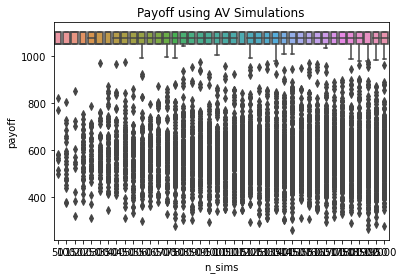

In [101]:
sns.boxplot(data=av_var_df, x='n_sims', y='payoff')
plt.title('Payoff using AV Simulations')
plt.show()

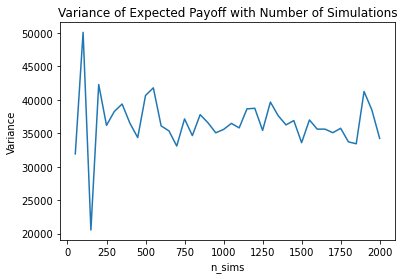

In [102]:
plt.plot(av_var_df.groupby(by=['n_sims'])['payoff'].var())
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Expected Payoff with Number of Simulations')
plt.show()

In [103]:
av_var_df['technique'] = 'AV'

In [104]:
mc_var_df['technique'] = 'MC'

In [105]:
var_df = pd.concat([av_var_df, mc_var_df]).reset_index(drop=True)

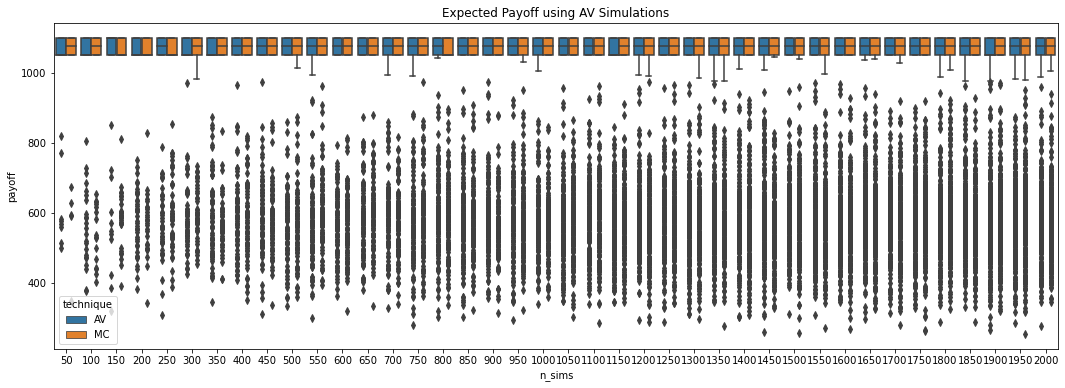

In [106]:
fig = plt.figure(figsize=(18,6))
sns.boxplot(data=var_df, x='n_sims', y='payoff', hue='technique')
plt.title('Expected Payoff using AV Simulations')
plt.show()

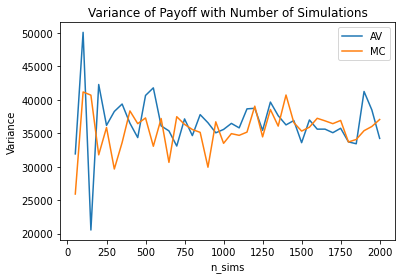

In [107]:
plt.plot(av_var_df.groupby(by=['n_sims'])['payoff'].var(), label='AV')
plt.plot(mc_var_df.groupby(by=['n_sims'])['payoff'].var(), label='MC')
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Payoff with Number of Simulations')
plt.legend(loc='upper right')
plt.show()